In [40]:
# Create a conda environment for TabPFN
# Please create conda environment manually via terminal: 
#conda create -n tabpfn-env python=3.10 -y
#conda activate tabpfn-env

# Install PyTorch (CPU version)
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cpu

# Install TabPFN and other dependencies
!pip install tabpfn matplotlib pandas scikit-learn

Shape: (113799, 24)
Names: ['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'G_batting', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'G_old']
Shape of Selected Data:  (90367, 17)


,playerID,fullName,yearID,age,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,BA
1,aardsda01,David Aardsma,2006,25.0,CHN,45,2,0,0,0,0,0,0.0,0.0,0,0.0,0.000000
3,aardsda01,David Aardsma,2008,27.0,BOS,47,1,0,0,0,0,0,0.0,0.0,0,1.0,0.000000
8,aardsda01,David Aardsma,2015,34.0,ATL,33,1,0,0,0,0,0,0.0,0.0,0,1.0,0.000000
9,aaronha01,Hank Aaron,1954,20.0,ML1,122,468,58,131,27,6,13,69.0,2.0,28,39.0,0.279915
10,aaronha01,Hank Aaron,1955,21.0,ML1,153,602,105,189,37,9,27,106.0,3.0,49,61.0,0.313953


In [93]:
import os
os.environ['TABPFN_ALLOW_CPU_LARGE_DATASET'] = '1'

import pandas as pd

# Read the Lahman data table
df = pd.read_csv('Batting.csv')

# Check the basic structure of data
print('Shape:', df.shape)
print('Names:', df.columns.tolist())
# Quick look
df.head()

# Add 'age' from people.csv
people_df = pd.read_csv("People.csv", encoding='unicode_escape')
people_df['fullName'] = people_df['nameFirst'] + ' ' + people_df['nameLast']
people_df = people_df[['playerID', 'birthYear', 'fullName']]

# Merge
df = pd.merge(df, people_df, on='playerID', how='left')
df['age'] = df['yearID'] - df['birthYear']

# Select the columns that are related to the batting performance
selected_columns = ['playerID','fullName', 'yearID', 'age', 'teamID',  'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO']
df_selected = df[selected_columns].copy()

# Add Batting average varieble
df_selected['BA'] = df_selected.apply(lambda row: row['H'] / row['AB'] if row['AB'] > 0 else None, axis=1)
# Drop NA data
df_selected = df_selected.dropna()
# Show the selected outcome
print('Shape of Selected Data: ', df_selected.shape)
df_selected.head()



Shape: (113799, 24)
Names: ['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'G_batting', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'G_old']
Shape of Selected Data:  (90367, 17)


,playerID,fullName,yearID,age,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,BA
1,aardsda01,David Aardsma,2006,25.0,CHN,45,2,0,0,0,0,0,0.0,0.0,0,0.0,0.000000
3,aardsda01,David Aardsma,2008,27.0,BOS,47,1,0,0,0,0,0,0.0,0.0,0,1.0,0.000000
8,aardsda01,David Aardsma,2015,34.0,ATL,33,1,0,0,0,0,0,0.0,0.0,0,1.0,0.000000
9,aaronha01,Hank Aaron,1954,20.0,ML1,122,468,58,131,27,6,13,69.0,2.0,28,39.0,0.279915
10,aaronha01,Hank Aaron,1955,21.0,ML1,153,602,105,189,37,9,27,106.0,3.0,49,61.0,0.313953


In [95]:
# Data copy (make original df fixed)
df_next = df_selected.copy()
# yearID + 1
df_next['yearID'] = df_next['yearID'] - 1
df_next.head()
df_next = df_next[['playerID', 'yearID', 'BA', 'HR']].rename(columns={'BA': 'BA_next', 'HR': 'HR_next'})

# Merge the data，future date = current data
df_final = pd.merge(df_selected, df_next, on=['playerID', 'yearID'], how='inner')

# Quick look
print("Shape of final dataset:", df_final.shape)
df_final[['playerID', 'fullName', 'yearID', 'age', 'BA', 'HR', 'BA_next', 'HR_next']].head()

Shape of final dataset: (70093, 19)


,playerID,fullName,yearID,age,BA,HR,BA_next,HR_next
0,aaronha01,Hank Aaron,1954,20.0,0.279915,13,0.313953,27
1,aaronha01,Hank Aaron,1955,21.0,0.313953,27,0.328407,26
2,aaronha01,Hank Aaron,1956,22.0,0.328407,26,0.321951,44
3,aaronha01,Hank Aaron,1957,23.0,0.321951,44,0.326123,30
4,aaronha01,Hank Aaron,1958,24.0,0.326123,30,0.354531,39


In [99]:
import numpy as np
from sklearn.preprocessing import StandardScaler

df_model = df_final.dropna().copy()

# Make new characters：BB/SO and HR rate
df_model['BB_SO'] = df_model['BB'] / (df_model['SO'] + 1e-5)  # denominator != 0
df_model['HR_rate'] = df_model['HR'] / (df_model['AB'] + 1e-5)

# Randomly select 10,000 samples
df_model = df_model.sample(n=1000, random_state=42).reset_index(drop=True)

# One-hot code teamID
df_model = pd.get_dummies(df_model, columns=['teamID'], drop_first=True)

# Make sure df_model has everything from num_cols
available_cols = df_model.columns.tolist()
num_cols = [col for col in ['age', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'BA', 'BB_SO', 'HR_rate'] if col in available_cols]

# Standarize
scaler = StandardScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

# Quick look
df_model.head()

,playerID,fullName,yearID,age,G,AB,R,H,2B,3B,...,teamID_SLF,teamID_SLN,teamID_TBA,teamID_TEX,teamID_TOR,teamID_TRO,teamID_WAS,teamID_WS1,teamID_WS2,teamID_WS8
0,shouncl01,Clyde Shoun,1938,-0.548015,-0.536984,-0.861617,-0.803595,-0.794161,-0.852709,-0.614129,...,False,True,False,False,False,False,False,False,False,False
1,fullesh01,Shorty Fuller,1895,-0.048229,1.194248,1.281309,1.740132,0.852469,0.187411,0.446543,...,False,False,False,False,False,False,False,False,False,False
2,quentca01,Carlos Quentin,2013,0.701449,0.308501,0.367931,0.468269,0.384480,1.132973,-0.614129,...,False,False,False,False,False,False,False,False,False,False
3,johnske05,Kelly Johnson,2014,0.951341,-1.140902,-0.891728,-0.835392,-0.863493,-0.758152,-0.614129,...,False,False,False,False,False,False,False,False,False,False
4,smithza01,Zane Smith,1989,0.201663,-0.698029,-0.997118,-0.835392,-0.915492,-0.758152,-0.614129,...,False,False,False,False,False,False,False,False,False,False


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Choose charater and target varieble
features = df_model.drop(columns=['playerID', 'fullName', 'yearID', 'BA_next', 'HR_next'])
target_ba = df_model['BA_next']
target_hr = df_model['HR_next']

# Split train / test
X_train, X_test, y_train_ba, y_test_ba = train_test_split(features, target_ba, test_size=0.2, random_state=42)
_, _, y_train_hr, y_test_hr = train_test_split(features, target_hr, test_size=0.2, random_state=42)

# Solve outcome function
def evaluate_model(model, X, y_true, target_name):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{target_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}')
    return rmse, r2

# Ridge Regression
ridge_ba = Ridge().fit(X_train, y_train_ba)
ridge_hr = Ridge().fit(X_train, y_train_hr)
print('Ridge Regression:')
evaluate_model(ridge_ba, X_test, y_test_ba, 'BA_next')
evaluate_model(ridge_hr, X_test, y_test_hr, 'HR_next')

# Random Forest
rf_ba = RandomForestRegressor(random_state=42).fit(X_train, y_train_ba)
rf_hr = RandomForestRegressor(random_state=42).fit(X_train, y_train_hr)
print('\nRandom Forest:')
evaluate_model(rf_ba, X_test, y_test_ba, 'BA_next')
evaluate_model(rf_hr, X_test, y_test_hr, 'HR_next')

# XGBoost
xgb_ba = XGBRegressor(random_state=42).fit(X_train, y_train_ba)
xgb_hr = XGBRegressor(random_state=42).fit(X_train, y_train_hr)
print('\nXGBoost:')
evaluate_model(xgb_ba, X_test, y_test_ba, 'BA_next')
evaluate_model(xgb_hr, X_test, y_test_hr, 'HR_next')

Ridge Regression:
BA_next - RMSE: 0.0925, R²: 0.1373
HR_next - RMSE: 5.7861, R²: 0.5193

Random Forest:
BA_next - RMSE: 0.0897, R²: 0.1887
HR_next - RMSE: 6.1472, R²: 0.4574

XGBoost:
BA_next - RMSE: 0.1072, R²: -0.1581
HR_next - RMSE: 6.5264, R²: 0.3884


(np.float64(6.526446314447192), 0.38840019702911377)

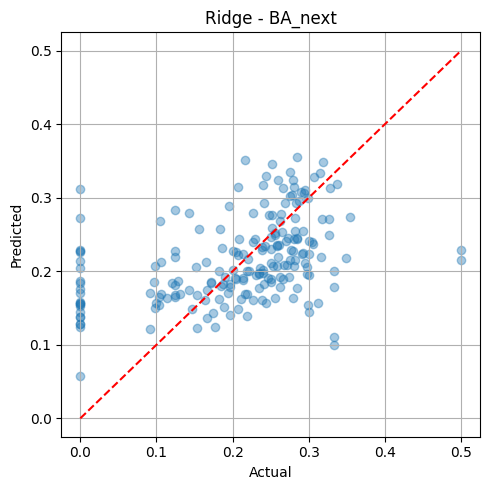

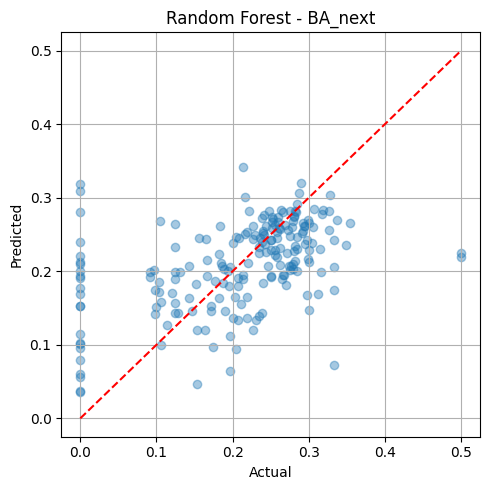

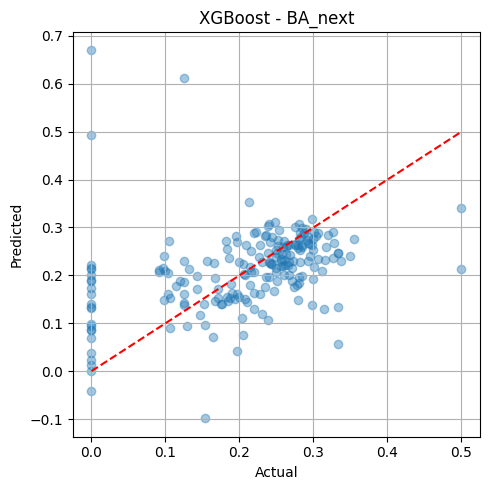

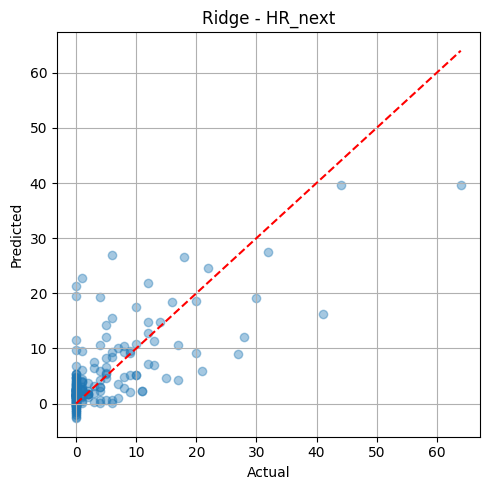

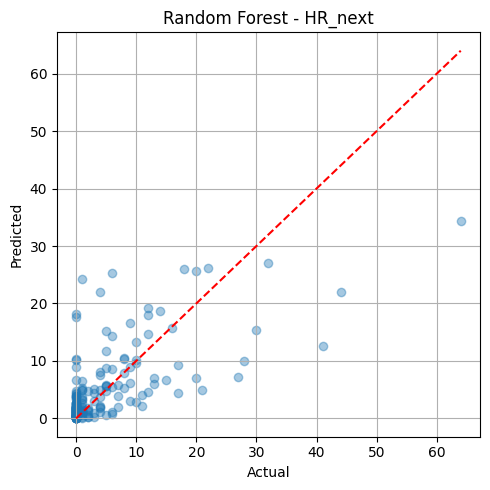

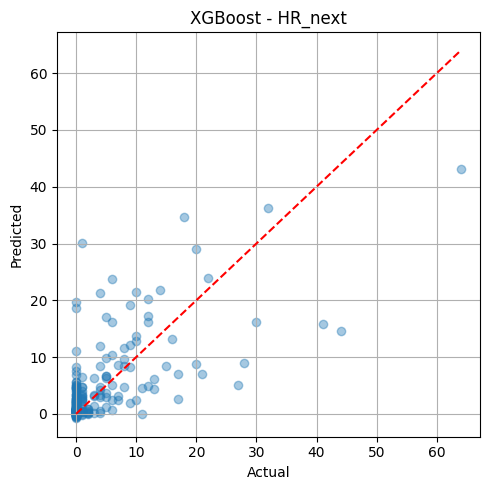

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

# Visualization function
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y = x 线
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# BA_next Visualization
plot_predictions(y_test_ba, ridge_ba.predict(X_test), 'Ridge - BA_next')
plot_predictions(y_test_ba, rf_ba.predict(X_test), 'Random Forest - BA_next')
plot_predictions(y_test_ba, xgb_ba.predict(X_test), 'XGBoost - BA_next')

# HR_next Visualization
plot_predictions(y_test_hr, ridge_hr.predict(X_test), 'Ridge - HR_next')
plot_predictions(y_test_hr, rf_hr.predict(X_test), 'Random Forest - HR_next')
plot_predictions(y_test_hr, xgb_hr.predict(X_test), 'XGBoost - HR_next')

In [39]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor

# Choose charater and target varieble
X = df_model.drop(columns=['playerID', 'fullName', 'yearID', 'BA_next', 'HR_next'])
y_ba = df_model['BA_next']
y_hr = df_model['HR_next']

# Split train / test
X_train_ba, X_test_ba, y_train_ba, y_test_ba = train_test_split(X, y_ba, test_size=0.2, random_state=42)
X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X, y_hr, test_size=0.2, random_state=42)

# Transfer to numpy
X_train_ba = X_train_ba.values.astype(np.float32)
X_test_ba = X_test_ba.values.astype(np.float32)
X_train_hr = X_train_hr.values.astype(np.float32)
X_test_hr = X_test_hr.values.astype(np.float32)
y_train_ba = y_train_ba.values.astype(np.float32)
y_test_ba = y_test_ba.values.astype(np.float32)
y_train_hr = y_train_hr.values.astype(np.float32)
y_test_hr = y_test_hr.values.astype(np.float32)

# Predict Model- BA
model_ba = TabPFNRegressor(device="cpu")
model_ba.fit(X_train_ba, y_train_ba)
y_pred_ba = model_ba.predict(X_test_ba)

# Predict Model-HR
model_hr = TabPFNRegressor(device="cpu")
model_hr.fit(X_train_hr, y_train_hr)
y_pred_hr = model_hr.predict(X_test_hr)

# Evaluation function
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: RMSE = {rmse:.4f}, R² = {r2:.4f}')
    return rmse, r2

evaluate(y_test_ba, y_pred_ba, 'TabPFN - BA_next')
evaluate(y_test_hr, y_pred_hr, 'TabPFN - HR_next')

C:\Users\ryanchc\anaconda3\envs\tabpfn-env\lib\site-packages\tabpfn\regressor.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)
C:\Users\ryanchc\anaconda3\envs\tabpfn-env\lib\site-packages\tabpfn\regressor.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)


TabPFN - BA_next: RMSE = 0.0828, R² = 0.3084
TabPFN - HR_next: RMSE = 6.2511, R² = 0.4389


(np.float64(6.251128438169246), 0.43891245126724243)

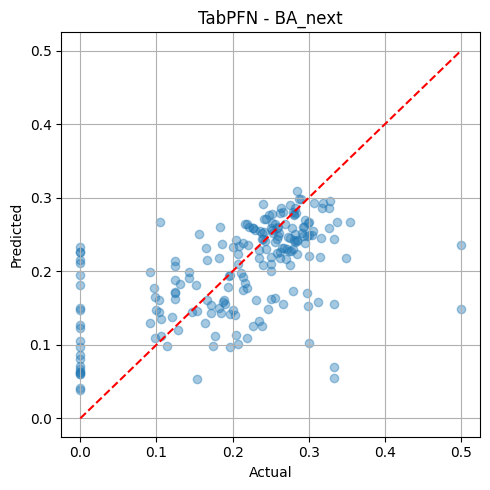

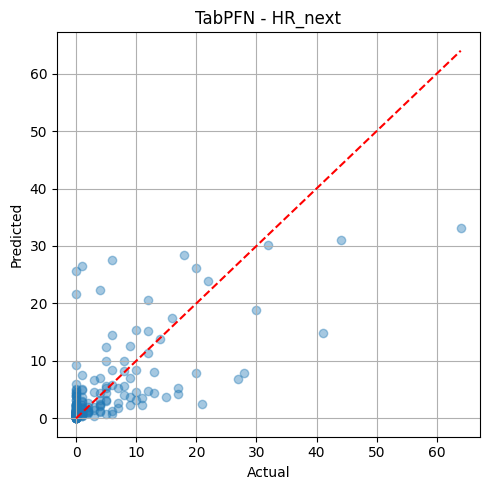

In [105]:
# Visualization function2
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_test_ba, y_pred_ba, 'TabPFN - BA_next')
plot_predictions(y_test_hr, y_pred_hr, 'TabPFN - HR_next')

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Model performance data
results = pd.DataFrame({
    'Model': ['Ridge', 'Random Forest', 'XGBoost', 'TabPFN'],
    'BA_RMSE': [0.0925, 0.0897, 0.1072, 0.0828],
    'BA_R2':   [0.1373, 0.1887, -0.1581, 0.3084],
    'HR_RMSE': [5.7861, 6.1472, 6.5264, 6.2511],
    'HR_R2':   [0.5193, 0.4574, 0.3884, 0.4389]
})
display(results)

,Model,BA_RMSE,BA_R2,HR_RMSE,HR_R2
0,Ridge,0.0925,0.1373,5.7861,0.5193
1,Random Forest,0.0897,0.1887,6.1472,0.4574
2,XGBoost,0.1072,-0.1581,6.5264,0.3884
3,TabPFN,0.0828,0.3084,6.2511,0.4389


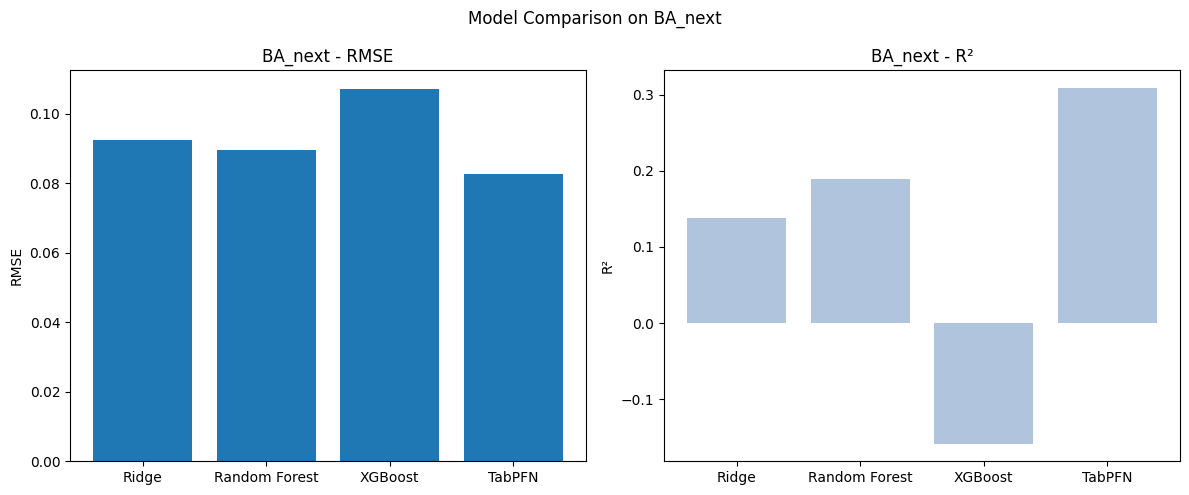

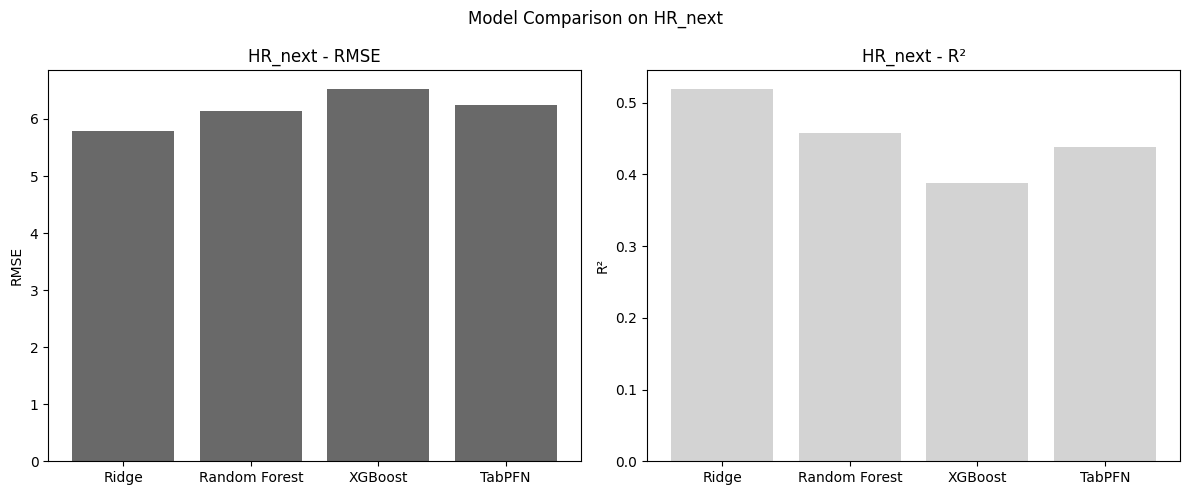

In [109]:
# BA_next RMSE and R²
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE
ax[0].bar(results['Model'], results['BA_RMSE'], color='C0')
ax[0].set_title('BA_next - RMSE')
ax[0].set_ylabel('RMSE')

# R^2
ax[1].bar(results['Model'], results['BA_R2'], color='#B0C4DE')
ax[1].set_title('BA_next - R²')
ax[1].set_ylabel('R²')

plt.suptitle('Model Comparison on BA_next')
plt.tight_layout()
plt.show()


# HR_next RMSE and R²
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE
ax[0].bar(results['Model'], results['HR_RMSE'], color='dimgray')
ax[0].set_title('HR_next - RMSE')
ax[0].set_ylabel('RMSE')

# R^2
ax[1].bar(results['Model'], results['HR_R2'], color='lightgray')
ax[1].set_title('HR_next - R²')
ax[1].set_ylabel('R²')

plt.suptitle('Model Comparison on HR_next')
plt.tight_layout()
plt.show()
